In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import matplotlib.style as mplstyle
import datetime
import statistics
from scipy import stats



#for list of style plt.style.available (https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html)
#mplstyle.use('bmh')

In [2]:
customer_profiles_df=pd.read_csv("./data/customer_profiles_table.csv")
transactions_df=pd.read_csv("./data/transactions_df.csv", parse_dates=["TX_DATETIME"])
terminal_profiles_df=pd.read_csv("./data/terminal_profiles_table.csv")

# Exploratory data analysis

This project will use a data set generator created by [Yann-Aël Le Borgne & Gianluca Bontempi](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html). The generator will create three dataset that reproduce the logs of a fictional card company, including fraudulent transactions. 

The logs are split in three dataset, column name in lower case are directly linked to the main dataset **transactions_df**:

1 - Customer profile

| Column | Type | Description |
| --- | --- | --- |
| CUSTOMER_ID | int64 | The customer unique ID|
|(x_customer_id,y_customer_id) | float64 | A pair of real coordinates (x_customer_id,y_customer_id) in a 100 * 100 grid, that defines the geographical location of the customer |
|(mean_amount, std_amount) | float64 | The mean and standard deviation of the transaction amounts for the customer, assuming that the transaction amounts follow a normal distribution. The mean_amount will be drawn from a uniform distribution (5,100) and the std_amount will be set as the mean_amount divided by two.|
| mean_nb_tx_per_day | float64 | The average number of transactions per day for the customer, assuming that the number of transactions per day follows a Poisson distribution. This number will be drawn from a uniform distribution (0,4) |

The generate_customer_profiles_table function provides an implementation for generating a table of customer profiles. It takes as input the number of customers for which to generate a profile and a random state for reproducibility. It returns a DataFrame containing the properties for each customer.

In [3]:
customer_profiles_df.head()

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals
0,0,54.881350,71.518937,62.262521,31.131260,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",78
1,1,42.365480,64.589411,46.570785,23.285393,3.567092,"[5, 160, 242, 378, 431, 475, 571, 762, 876, 93...",85
2,2,96.366276,38.344152,80.213879,40.106939,2.115580,"[316, 406, 447, 523, 968, 1200, 1318, 1365, 16...",70
3,3,56.804456,92.559664,11.748426,5.874213,0.348517,"[65, 94, 113, 364, 401, 433, 485, 651, 672, 77...",70
4,4,2.021840,83.261985,78.924891,39.462446,3.480049,"[372, 614, 774, 1362, 1446, 1564, 1637, 1939, ...",65


In [4]:
customer_profiles_df.shape

(5000, 8)

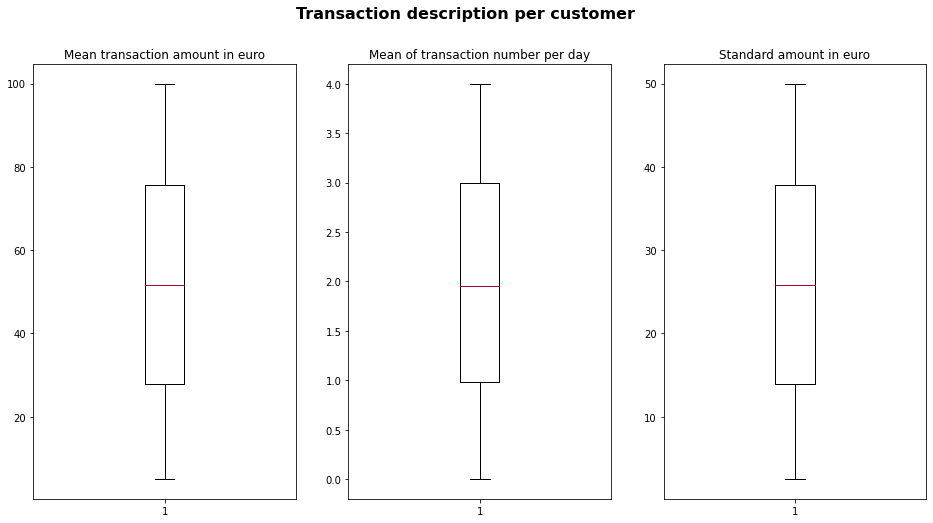

In [5]:
fig, ax = plt.subplots(1,3,figsize=(16,8))
mplstyle.use('bmh')
fig.suptitle("Transaction description per customer", fontsize=16, fontweight='bold')

ax[0].boxplot(customer_profiles_df["mean_amount"])
ax[1].boxplot(customer_profiles_df["mean_nb_tx_per_day"])
ax[2].boxplot(customer_profiles_df["std_amount"])

ax[0].title.set_text("Mean transaction amount in euro")
ax[1].title.set_text("Mean of transaction number per day")
ax[2].title.set_text("Standard amount in euro")


plt.show()

2 - Terminal profile

| Column | Type | Description |
| --- | --- | --- |
| TERMINAL_ID | int64 | The terminal ID|
| (x_terminal_id,y_terminal_id) | float64 | A pair of real coordinates (x_terminal_id,y_terminal_id) in a 100 * 100 grid, that defines the geographical location of the terminal|

The generate_terminal_profiles_table function provides an implementation for generating a table of terminal profiles. It takes as input the number of terminals for which to generate a profile and a random state for reproducibility. It returns a DataFrame containing the properties for each terminal.

In [6]:
terminal_profiles_df.head()

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,41.702200,72.032449
1,1,0.011437,30.233257
2,2,14.675589,9.233859
3,3,18.626021,34.556073
4,4,39.676747,53.881673


In [7]:
terminal_profiles_df.shape

(10000, 3)

3 - Transaction list


| Column | Type | Description |
| --- | --- | --- |
| TRANSACTION_ID  | int64 | A unique identifier for the transaction|
| TX_DATETIME  | object | Date and time at which the transaction occurs|
| CUSTOMER_ID  | int64 | The identifier for the customer. Each customer has a unique identifier|
| TERMINAL_ID  | int64 | The identifier for the merchant (or more precisely the terminal). Each terminal has a unique identifier|
| TX_AMOUNT	  | int64 | The amount of the transaction|
| TX_FRAUD  | int64 | A binary variable, with the value 0 for a legitimate transaction, or the value 1 for a fraudulent transaction|
| TX_FRAUD_SCENARIO | int64 | Referencing the fraud scenario, 0 indicate a genuine transaction|

* Fraud scenario:

Scenario 1: Any transaction whose amount is more than 220 is a fraud. This scenario is not inspired by a real-world scenario. 

Scenario 2: Every day, a list of 6 terminals is drawn at random. All transactions on these terminals in the next 28 days will be marked as fraudulent. This scenario simulates a criminal use of a terminal, through phishing for example. 

Scenario 3: Every day, a list of 6 customers is drawn at random. In the next 14 days, 1/3 of their transactions have their amounts multiplied by 5 and marked as fraudulent. This scenario simulates a card-not-present fraud where the credentials of a customer have been leaked. 

Scenario 4 : Every day a list of 4 customer is drawn at random. In the next 3 days every transaction have their amount multiplied by a random number between 3 and 6. This scenario simulate a hit and run scenario where fraudster try to exit as much funds as possible before being detected.

In [8]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [9]:
#Fraud repartition

transactions_df_temp = transactions_df.groupby("TX_FRAUD_SCENARIO").count()
transactions_df_temp["percentage"] = (transactions_df_temp[["TX_FRAUD"]]/
                                      transactions_df_temp[["TX_FRAUD"]].sum())*100
transactions_df_temp[["TX_FRAUD","percentage"]]

,TX_FRAUD,percentage
TX_FRAUD_SCENARIO,,
0,1738126,99.086227
1,972,0.055411
2,9067,0.516887
3,3907,0.222728
4,2083,0.118747


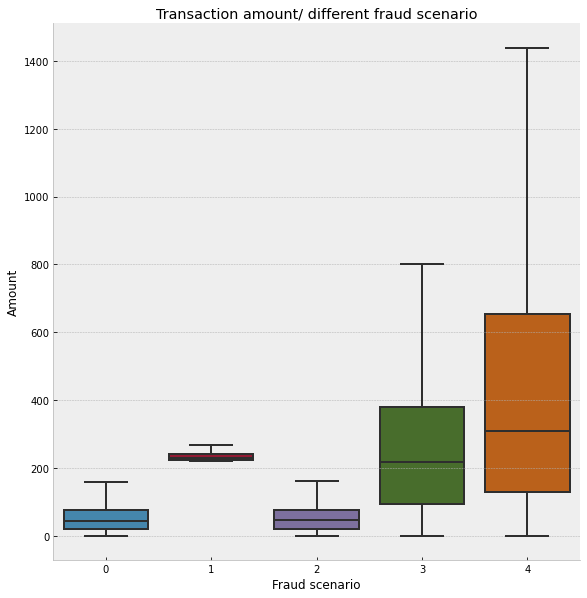

In [10]:
sns.displot(color = "rocket", height=8)

ax = sns.boxplot(x = "TX_FRAUD_SCENARIO",y = "TX_AMOUNT", data= transactions_df, showfliers = False)
ax.set_title("Transaction amount/ different fraud scenario")
ax.set_ylabel("Amount")
ax.set_xlabel("Fraud scenario");

In [11]:
#convert the transactions_df.TX_DATETIME column to a mor
pop = pd.to_datetime(transactions_df["TX_DATETIME"], format='%Y, %m, %d').dt.date
transactions_df_temp = transactions_df
transactions_df_temp["temp_date"] = pop

In [12]:
scn_0 = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO == 0]
scn_1 = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO == 1]
scn_2 = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO == 2]
scn_3 = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO == 3]
scn_4 = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO == 4]
scn_fraud = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO != 0]

In [13]:
temp_0_sum = scn_0.resample("d", on="TX_DATETIME").sum()
temp_1_sum = scn_1.resample("d", on="TX_DATETIME").sum()
temp_2_sum = scn_2.resample("d", on="TX_DATETIME").sum()
temp_3_sum = scn_3.resample("d", on="TX_DATETIME").sum()
temp_4_sum = scn_4.resample("d", on="TX_DATETIME").sum()
temp_fraud_sum = scn_fraud.resample("d", on="TX_DATETIME").sum()

temp_0_count = scn_0.resample("d", on="TX_DATETIME").count()
temp_1_count = scn_1.resample("d", on="TX_DATETIME").count()
temp_2_count = scn_2.resample("d", on="TX_DATETIME").count()
temp_3_count = scn_3.resample("d", on="TX_DATETIME").count()
temp_4_count = scn_4.resample("d", on="TX_DATETIME").count()
temp_fraud_count = scn_fraud.resample("d", on="TX_DATETIME").sum()

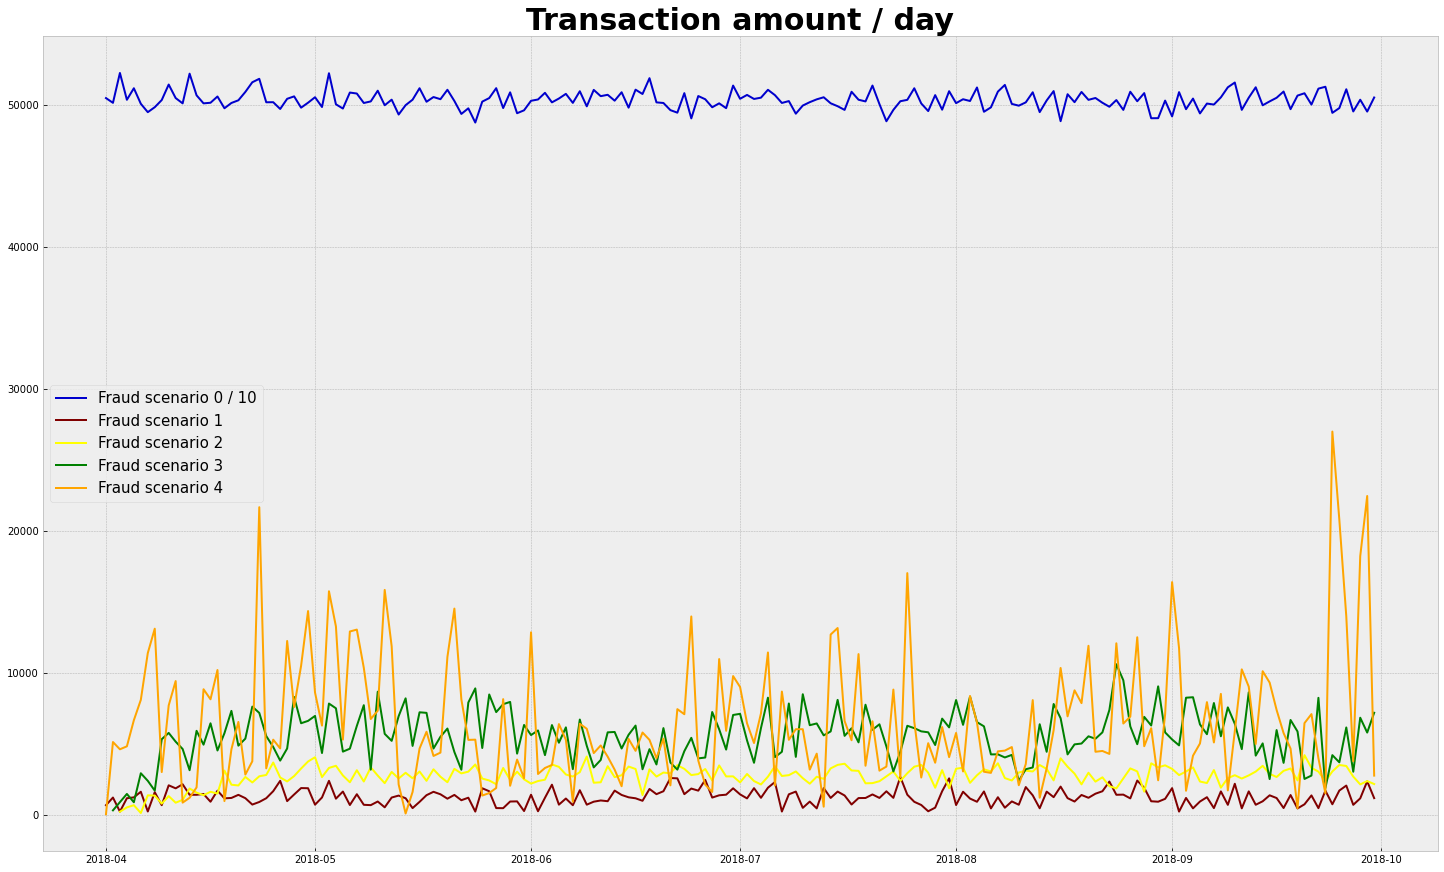

In [14]:
fig, ax=plt.subplots(figsize=(25, 15))
mplstyle.use('bmh')
plt.plot(temp_0_sum.index  , (temp_0_sum.TX_AMOUNT/10),label="Fraud scenario 0 / 10", color = "mediumblue")
plt.plot(temp_1_sum.index, temp_1_sum.TX_AMOUNT,label="Fraud scenario 1",color = "maroon")
plt.plot(temp_2_sum.index, temp_2_sum.TX_AMOUNT,label="Fraud scenario 2",color = "yellow")
plt.plot(temp_3_sum.index, temp_3_sum.TX_AMOUNT,label="Fraud scenario 3",color = "green")
plt.plot(temp_4_sum.index, temp_4_sum.TX_AMOUNT,label="Fraud scenario 4",color ="orange")

plt.title("Transaction amount / day", fontsize=30, fontweight='bold')
ax.legend(fontsize=15)
plt.show()

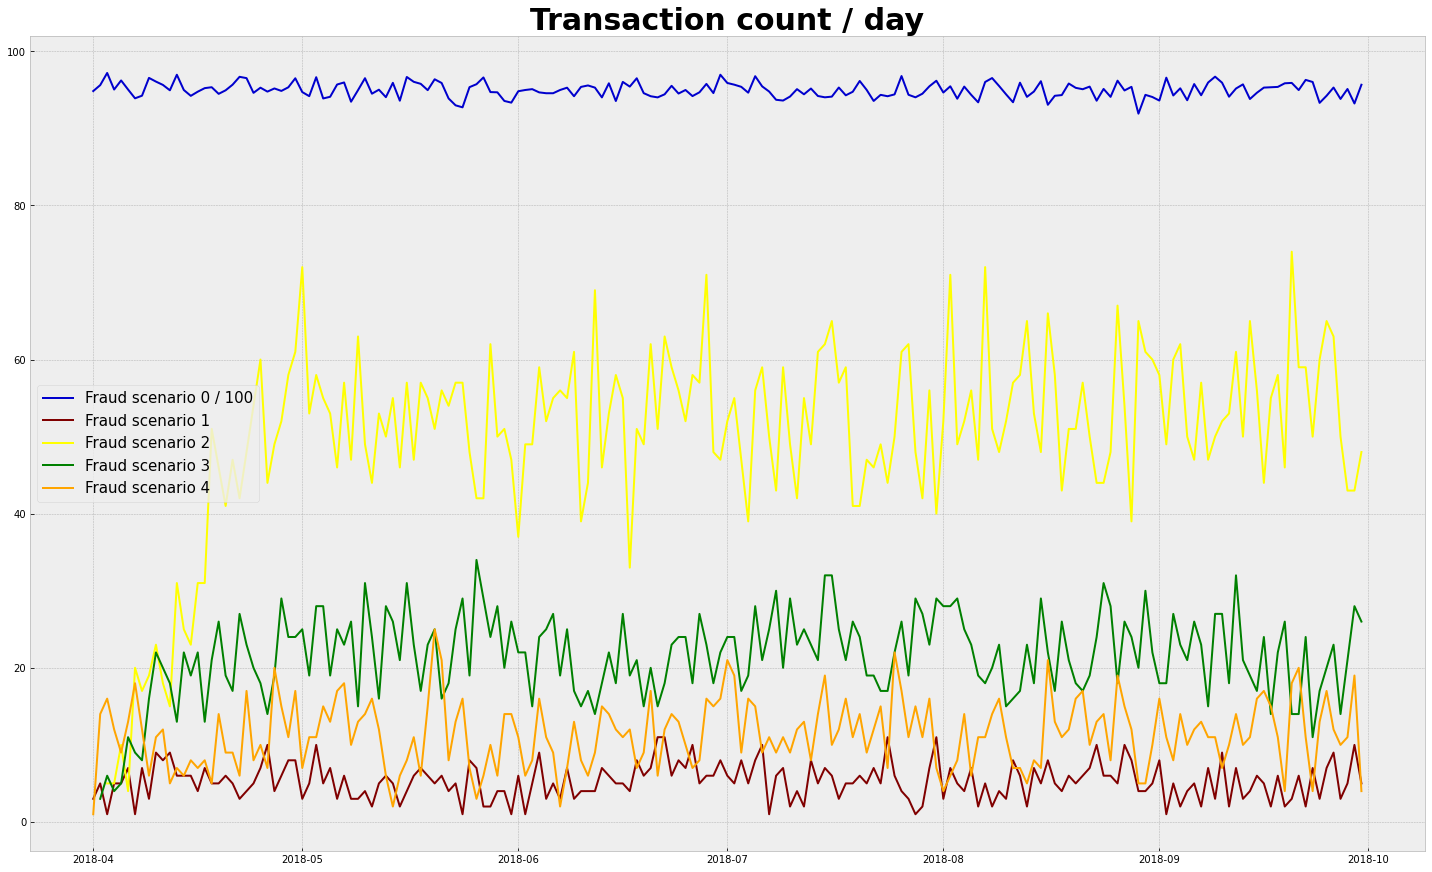

In [15]:
fig, ax=plt.subplots(figsize=(25, 15))


plt.plot(temp_0_count.index, (temp_0_count.TX_AMOUNT/100),label="Fraud scenario 0 / 100", color = "mediumblue")
plt.plot(temp_1_count.index, temp_1_count.TX_AMOUNT,label="Fraud scenario 1",color = "maroon")
plt.plot(temp_2_count.index, temp_2_count.TX_AMOUNT,label="Fraud scenario 2",color = "yellow")
plt.plot(temp_3_count.index, temp_3_count.TX_AMOUNT,label="Fraud scenario 3",color = "green")
plt.plot(temp_4_count.index, temp_4_count.TX_AMOUNT,label="Fraud scenario 4",color ="orange")

plt.title("Transaction count / day", fontsize=30, fontweight='bold')
ax.legend(fontsize=15)
plt.show()

# Dataframe transformation

In [16]:
from datetime import datetime

#date transaformation
# could be optimised
def func_date_monday (data1):
  
    if data1.weekday() == 0:
        return 1
    else:
        return 0
    
def func_date_tuesday (data1):
   
    if data1.weekday() == 1:
        return 1
    else:
        return 0

def func_date_wednesday (data1):
    
    if data1.weekday() == 2:
        return 1
    else:
        return 0
def func_date_thursday (data1):
    
    if data1.weekday() == 3:
        return 1
    else:
        return 0
def func_date_friday (data1):
   
    if data1.weekday() == 4:
        return 1
    else:
        return 0
def func_date_saturday (data1):
    
    if data1.weekday() == 5:
        return 1
    else:
        return 0
def func_date_sunday (data1):
   
    if data1.weekday() == 6:
        return 1
    else:
        return 0

In [17]:
# could be optimised
transactions_df["is_monday"]=transactions_df.TX_DATETIME.apply(func_date_monday);
transactions_df["is_tuesday"]=transactions_df.TX_DATETIME.apply(func_date_tuesday);
transactions_df["is_wednesday"]=transactions_df.TX_DATETIME.apply(func_date_wednesday);
transactions_df["is_thursday"]=transactions_df.TX_DATETIME.apply(func_date_thursday);
transactions_df["is_friday"]=transactions_df.TX_DATETIME.apply(func_date_friday);
transactions_df["is_saturday"]=transactions_df.TX_DATETIME.apply(func_date_saturday);
transactions_df["is_sunday"]=transactions_df.TX_DATETIME.apply(func_date_sunday)

In [18]:
def timestamp1(data1):

    if data1.hour <=6:
        return 1
    else:
        return 0
    
def timestamp2(data1):
   
    if data1.hour >6 and data1.hour <= 12:
        return 1
    else:
        return 0
def timestamp3(data1):
  
    if data1.hour >12 and data1.hour <= 18:
        return 1
    else:
        return 0
def timestamp4(data1):
  
    if data1.hour >18:
        return 1
    else:
        return 0

In [19]:
transactions_df["hour_1_4"]=transactions_df.TX_DATETIME.apply(timestamp1)
transactions_df["hour_2_4"]=transactions_df.TX_DATETIME.apply(timestamp2)
transactions_df["hour_3_4"]=transactions_df.TX_DATETIME.apply(timestamp3)
transactions_df["hour_4_4"]=transactions_df.TX_DATETIME.apply(timestamp4)

In [20]:
def tran_hist (temp_tran_id, window_days):
#sort transaction id by date time and reindex the df
    
    transaction_id_temp_df = temp_tran_id.sort_values("TX_DATETIME")
    transaction_id_temp_df.index = transaction_id_temp_df["TX_DATETIME"]

#for loop that will sum number of transaction and average amount on defined period for 
    for period in window_days:
        sum_tran_period = transaction_id_temp_df["TX_AMOUNT"].rolling(str(period) + "d").sum()
        count_tran_period =transaction_id_temp_df["TX_AMOUNT"].rolling(str(period)+"d").count()
        average_tran_period = sum_tran_period/count_tran_period
        
        transaction_id_temp_df["average_tx_last"+ str(period) + "days"] = average_tran_period
        transaction_id_temp_df["tx_count_over_last"+ str(period) + "days"] = count_tran_period


    return transaction_id_temp_df

In [21]:
# create columns with rolling transaction history 
temp_bis_df=transactions_df.groupby("CUSTOMER_ID").apply(lambda x: tran_hist(x, window_days=[1,7,30]))
temp_bis_df=temp_bis_df.sort_values("TX_TIME_SECONDS").reset_index(drop=True)
transactions_df = temp_bis_df

In [22]:
def terminal_hist (terminal_id, window_days, period_uncertainty = 10):

#sort terminaid by date time and reindex the df
    
    terminal_id_temp_df = terminal_id.sort_values("TX_DATETIME")
    terminal_id_temp_df.index = terminal_id_temp_df["TX_DATETIME"]

#for loop that will sum number of transaction and average amount on defined period for 
    for period in window_days:
        count_genuine_tran_period = terminal_id_temp_df["TX_FRAUD"].rolling(min_periods= period_uncertainty, 
                                                                            window = (str(period) + "d")).count()
        count_fraudulent__tran_period =terminal_id_temp_df["TX_FRAUD"].rolling(str(period)+"d").sum()
        fraud_rate_period = count_fraudulent__tran_period/count_genuine_tran_period
        
        terminal_id_temp_df["average_terminal_fraud_rate_last"+ str(period) + "days"] = fraud_rate_period


    return terminal_id_temp_df

In [23]:
temp_bis_df=transactions_df.groupby("TERMINAL_ID").apply(lambda x: terminal_hist(x, window_days =[15,30]))
temp_bis_df=temp_bis_df.sort_values("TX_TIME_SECONDS").reset_index(drop=True)
transactions_df = temp_bis_df

In [24]:
transactions_df = transactions_df.fillna(0)

In [25]:
def outlier_rate (row):
    
    temp_df = row
    cust_id = temp_df.CUSTOMER_ID
    tx_time = temp_df.TX_TIME_SECONDS
    tx_amount = temp_df.TX_AMOUNT
    
    mean = transactions_df.TX_AMOUNT[(transactions_df.CUSTOMER_ID == cust_id) & 
                                       (transactions_df.TX_TIME_SECONDS > tx_time)].mean()
    std = transactions_df.TX_AMOUNT[(transactions_df.CUSTOMER_ID == cust_id) & 
                                    (transactions_df.TX_TIME_SECONDS > tx_time)].std()
    upper_outlier_dist = 0
    
    if (std + mean) < tx_amount:
        upper_outlier_dist = (tx_amount - (std + mean))
    else:
        upper_outlier_dist = 0

    return upper_outlier_dist

In [26]:
%time transactions_df["upper_outlier_distance"]=transactions_df.apply(lambda x: outlier_rate(x),axis = 1)


CPU times: user 5h 55min 40s, sys: 16min 7s, total: 6h 11min 48s
Wall time: 2h 3min 3s


In [61]:
transactions_df.to_csv("./data/transactions_bis_df.csv", index = False)



In [60]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,temp_date,...,hour_4_4,average_tx_last1days,tx_count_over_last1days,average_tx_last7days,tx_count_over_last7days,average_tx_last30days,tx_count_over_last30days,average_terminal_fraud_rate_last15days,average_terminal_fraud_rate_last30days,upper_outlier_distance
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0,2018-04-01,...,0,57.16,1.0,57.16,1.0,57.16,1.0,0.0,0.0,0.000000
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0,2018-04-01,...,0,81.51,1.0,81.51,1.0,81.51,1.0,0.0,0.0,0.000000
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0,2018-04-01,...,0,146.00,1.0,146.00,1.0,146.00,1.0,0.0,0.0,27.835762
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0,2018-04-01,...,0,64.49,1.0,64.49,1.0,64.49,1.0,0.0,0.0,0.000000
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0,2018-04-01,...,0,50.99,1.0,50.99,1.0,50.99,1.0,0.0,0.0,0.000000


# Machine learning

In [27]:
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [28]:
X=transactions_df[['TX_AMOUNT', 'is_monday', 'is_tuesday', 'is_wednesday',
       'is_thursday', 'is_friday', 'is_saturday', 'is_sunday', 'hour_1_4',
       'hour_2_4', 'hour_3_4', 'hour_4_4', 'average_tx_last1days',
       'tx_count_over_last1days', 'average_tx_last7days',
       'tx_count_over_last7days', 'average_tx_last30days',
       'tx_count_over_last30days','average_terminal_fraud_rate_last15days',
       'average_terminal_fraud_rate_last30days',"upper_outlier_distance"]]  # Features
y=transactions_df['TX_FRAUD'] 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

## Random forest

In [30]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
model_random=RandomForestClassifier(n_estimators=200, n_jobs=-1)

#Train the model using the training sets y_pred=clf.predict(X_test)
%time model_random.fit(X_train,y_train)
%time y_pred_random=model_random.predict(X_test)

CPU times: user 23min 27s, sys: 6.38 s, total: 23min 33s
Wall time: 3min 6s
CPU times: user 5.41 s, sys: 101 ms, total: 5.51 s
Wall time: 762 ms


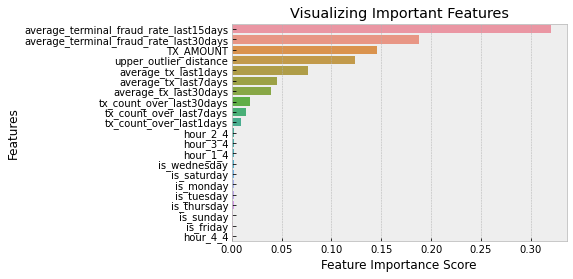

In [31]:
feature_imp = pd.Series(model_random.feature_importances_,index=X.columns).sort_values(ascending=False)
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

looking for the granular details

## XG Boost

In [32]:
model_XGBC = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=20, min_child_weight=1,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=20, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

model_XGBC = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model_XGBC.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [33]:
%time model_XGBC.fit(X_train, y_train)
%time y_pred_XGBC = model_XGBC.predict(X_test)

CPU times: user 10min 15s, sys: 36.1 s, total: 10min 51s
Wall time: 1min 23s
CPU times: user 910 ms, sys: 89.9 ms, total: 1 s
Wall time: 127 ms


In [34]:
accuracy_XGBC = accuracy_score(y_test, y_pred_XGBC)
accuracy_XGBC

0.9985463127650841

#en cours, on tente de trouver les bon settings

parameters = {'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [0.1], 
              'max_depth': [7,20],
              'min_child_weight': [10,25],
              'colsample_bytree': [0.8, 1],
              'n_estimators': [100,200],
              "reg_alpha"   : [0.5,1],
              "reg_lambda"  : [2,5],
              "gamma"       : [1,3]}

model_XGBC_RandomizedSearchCV = RandomizedSearchCV(model_XGBC, 
                         param_distributions = parameters,  
                         n_iter = 2, # you want 5 here not 25 if I understand you correctly 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)
%time search = model_XGBC_RandomizedSearchCV.fit(X_train, y_train)
search.best_params_

y_pred_XGBC_bis = search.predict(X_test)

accuracy_XGBC_bis = accuracy_score(y_test, y_pred_XGBC_bis)
accuracy_XGBC_bis = 0.9979933415423906

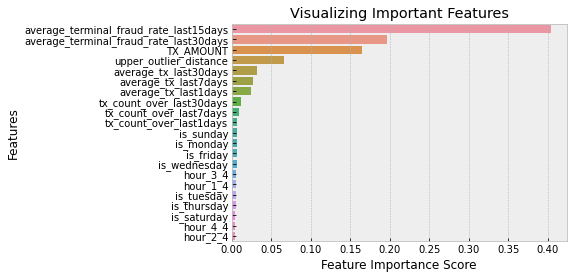

In [35]:
feature_imp = pd.Series(model_XGBC.feature_importances_,index=X.columns).sort_values(ascending=False)
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

In [36]:
from sklearn import metrics
print("Accuracy XG Boost:",metrics.accuracy_score(y_test, y_pred_XGBC))
print("Accuracy random forest:",metrics.accuracy_score(y_test, y_pred_random))

Accuracy XG Boost: 0.9985463127650841
Accuracy random forest: 0.9983809914717016


In [37]:
result = pd.DataFrame(data=transactions_df.TRANSACTION_ID, columns=["TRANSACTION_ID"])
result.insert(1, "TX_FRAUD_SCENARIO", transactions_df.TX_FRAUD_SCENARIO, True)
result.insert(1, "TX_FRAUD", transactions_df.TX_FRAUD, True)
result.insert(1, "TX_AMOUNT", transactions_df.TX_AMOUNT, True)

In [38]:
result.head(10)

,TRANSACTION_ID,TX_AMOUNT,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,57.16,0,0
1,1,81.51,0,0
2,2,146.00,0,0
3,3,64.49,0,0
4,4,50.99,0,0
5,5,44.71,0,0
6,6,96.03,0,0
7,7,24.36,0,0
8,8,26.34,0,0
9,9,59.07,0,0


In [39]:
prediction = X
%time tem_p = model_random.predict(X)
%time tem_p_2 = model_random.predict_proba(X)[:,1]
result.insert(1, "fraud_prediction_random_forest", tem_p, True)
result.insert(1, "fraud_prediction_rate_random_forest", tem_p_2, True)

%time tem_p = model_XGBC.predict(X)
%time tem_p_2 = model_XGBC.predict_proba(X)[:,1]
result.insert(1, "fraud_prediction_XGB", tem_p, True)
result.insert(1, "fraud_prediction_rate_XGB", tem_p_2, True)

CPU times: user 53.3 s, sys: 571 ms, total: 53.9 s
Wall time: 7.41 s
CPU times: user 53.9 s, sys: 257 ms, total: 54.2 s
Wall time: 7.18 s
CPU times: user 7.29 s, sys: 561 ms, total: 7.85 s
Wall time: 1.21 s
CPU times: user 8.12 s, sys: 733 ms, total: 8.86 s
Wall time: 1.19 s


In [40]:
result.head()

,TRANSACTION_ID,fraud_prediction_rate_XGB,fraud_prediction_XGB,fraud_prediction_rate_random_forest,fraud_prediction_random_forest,TX_AMOUNT,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,0.000266,0,0.0,0,57.16,0,0
1,1,0.000272,0,0.0,0,81.51,0,0
2,2,0.001520,0,0.0,0,146.00,0,0
3,3,0.000600,0,0.0,0,64.49,0,0
4,4,0.000200,0,0.0,0,50.99,0,0


In [41]:
#random forest
result["false_positive_rf"] = np.where((result["fraud_prediction_random_forest"] == 1) &
                                   (result["TX_FRAUD"] == 0), 1,0)

result["fraud_missed_rf"] = np.where((result["fraud_prediction_random_forest"] == 0) &
                                   (result["TX_FRAUD"] == 1), 1,0 )

result["fraud_catch_rf"] = np.where((result["fraud_prediction_random_forest"] == result["TX_FRAUD"])&
                                   (result["TX_FRAUD"] == 1), 1,0)

result["genuine_transaction_rf"] = np.where((result["fraud_prediction_random_forest"] == result["TX_FRAUD"])&
                                   (result["TX_FRAUD"] == 0), 1,0)
#for XGBC

result["false_positive_XGB"] = np.where((result["fraud_prediction_XGB"] == 1) &
                                   (result["TX_FRAUD"] == 0), 1,0)

result["fraud_missed_XGB"] = np.where((result["fraud_prediction_XGB"] == 0) &
                                   (result["TX_FRAUD"] == 1), 1,0 )

result["fraud_catch_XGB"] = np.where((result["fraud_prediction_XGB"] == result["TX_FRAUD"])&
                                   (result["TX_FRAUD"] == 1), 1,0)

result["genuine_transaction_XGB"] = np.where((result["fraud_prediction_XGB"] == result["TX_FRAUD"])&
                                   (result["TX_FRAUD"] == 0), 1,0)                               

In [42]:
res_scn_0 = result[result.TX_FRAUD_SCENARIO == 0]
res_scn_1 = result[result.TX_FRAUD_SCENARIO == 1]
res_scn_2 = result[result.TX_FRAUD_SCENARIO == 2]
res_scn_3 = result[result.TX_FRAUD_SCENARIO == 3]
res_scn_4 = result[result.TX_FRAUD_SCENARIO == 4]
res_scn_fraud = result[result.TX_FRAUD_SCENARIO != 0]

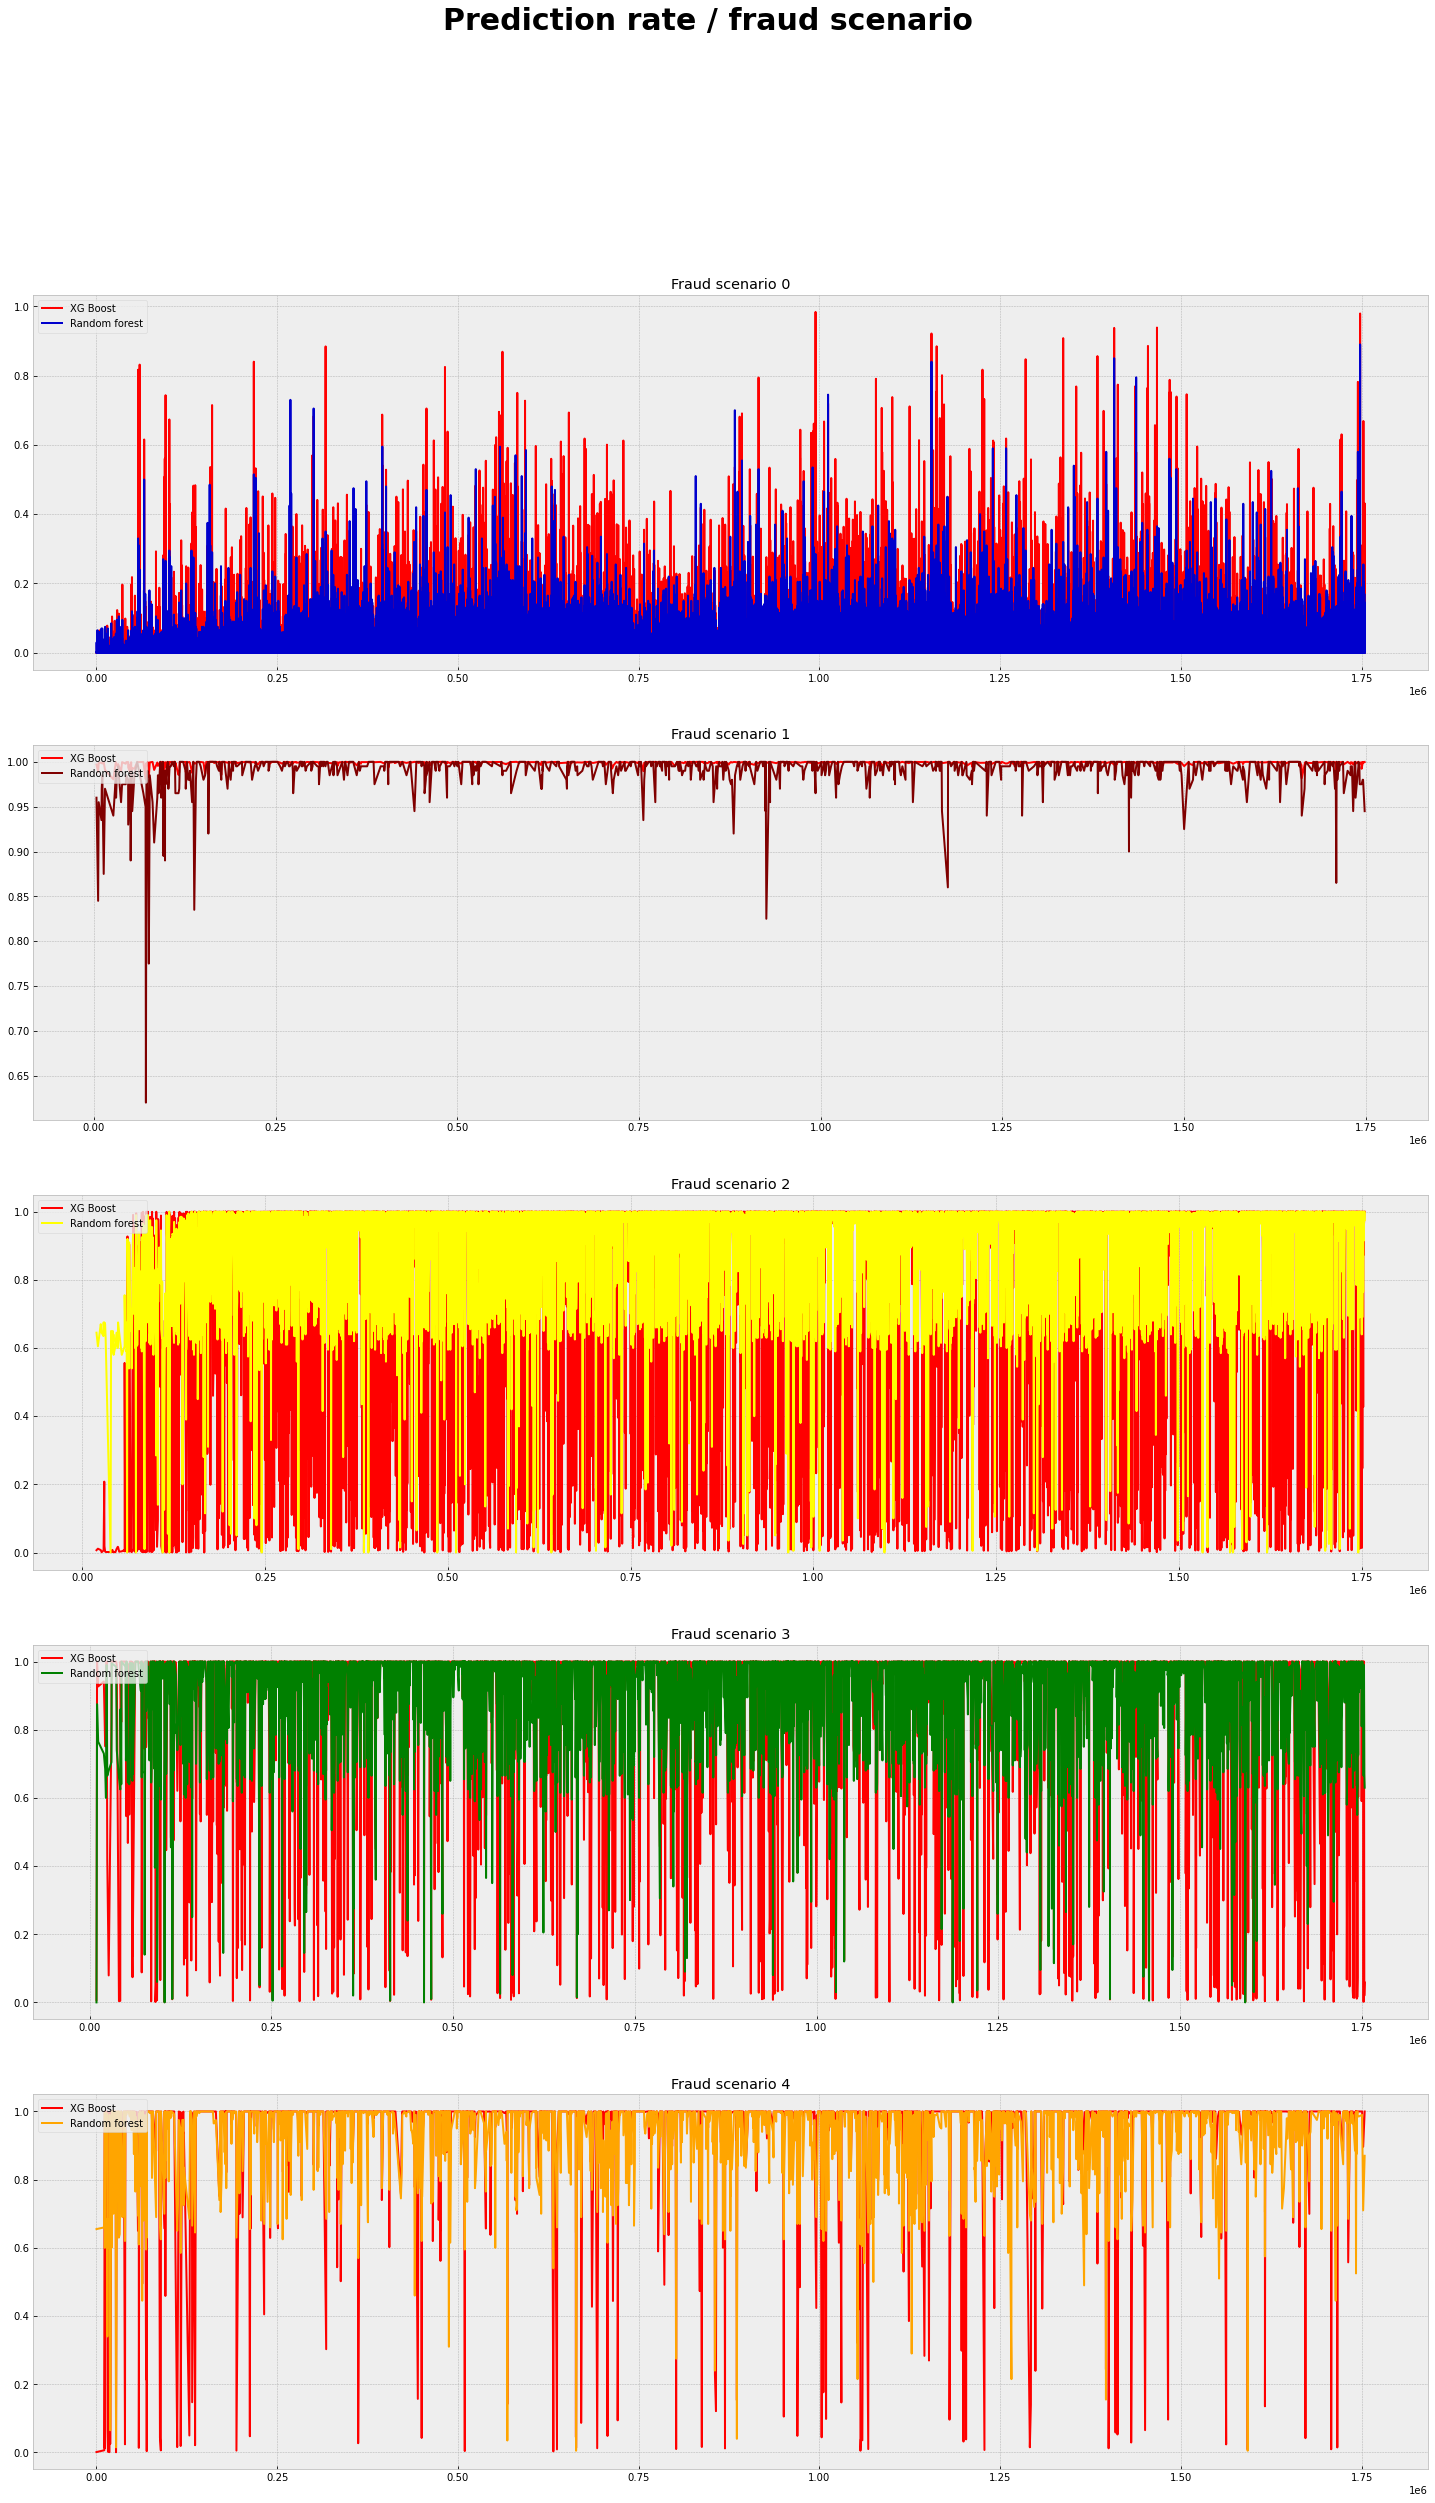

In [43]:
fig, ax=plt.subplots(5,1,figsize=(25, 40))
mplstyle.use('bmh')
fig.suptitle("Prediction rate / fraud scenario", fontsize=30, fontweight='bold')

ax[0].plot(res_scn_0.index, res_scn_0.fraud_prediction_rate_XGB, color = "red",label="XG Boost")
ax[0].plot(res_scn_0.index, res_scn_0.fraud_prediction_rate_random_forest, color = "mediumblue", label="Random forest")

ax[1].plot(res_scn_1.index, res_scn_1.fraud_prediction_rate_XGB,color = "red",label="XG Boost")
ax[1].plot(res_scn_1.index, res_scn_1.fraud_prediction_rate_random_forest,color = "maroon", label="Random forest")

ax[2].plot(res_scn_2.index, res_scn_2.fraud_prediction_rate_XGB,color = "red",label="XG Boost")
ax[2].plot(res_scn_2.index, res_scn_2.fraud_prediction_rate_random_forest,color = "yellow", label="Random forest")


ax[3].plot(res_scn_3.index, res_scn_3.fraud_prediction_rate_XGB,color = "red",label="XG Boost")
ax[3].plot(res_scn_3.index, res_scn_3.fraud_prediction_rate_random_forest,color = "green", label="Random forest")


ax[4].plot(res_scn_4.index, res_scn_4.fraud_prediction_rate_XGB,color ="red",label="XG Boost")
ax[4].plot(res_scn_4.index, res_scn_4.fraud_prediction_rate_random_forest,color ="orange", label="Random forest")

ax[0].legend(loc=2)
ax[1].legend(loc=2)
ax[2].legend(loc=2)
ax[3].legend(loc=2)
ax[4].legend(loc=2)

ax[0].title.set_text("Fraud scenario 0")
ax[1].title.set_text("Fraud scenario 1")
ax[2].title.set_text("Fraud scenario 2")
ax[3].title.set_text("Fraud scenario 3")
ax[4].title.set_text("Fraud scenario 4")

plt.show()

Looking for fraud scenario

In [44]:
result.columns

Index(['TRANSACTION_ID', 'fraud_prediction_rate_XGB', 'fraud_prediction_XGB',
       'fraud_prediction_rate_random_forest', 'fraud_prediction_random_forest',
       'TX_AMOUNT', 'TX_FRAUD', 'TX_FRAUD_SCENARIO', 'false_positive_rf',
       'fraud_missed_rf', 'fraud_catch_rf', 'genuine_transaction_rf',
       'false_positive_XGB', 'fraud_missed_XGB', 'fraud_catch_XGB',
       'genuine_transaction_XGB'],
      dtype='object')

In [45]:
result = result[['TRANSACTION_ID','TX_AMOUNT','TX_FRAUD_SCENARIO','TX_FRAUD','fraud_prediction_random_forest',
                 'fraud_prediction_rate_random_forest', 'false_positive_rf',
                 'fraud_missed_rf', 'fraud_catch_rf', 'genuine_transaction_rf','fraud_prediction_XGB',
                 'fraud_prediction_rate_XGB', 'false_positive_XGB',
                 'fraud_missed_XGB', 'fraud_catch_XGB', 'genuine_transaction_XGB']]

# Confusion matrix

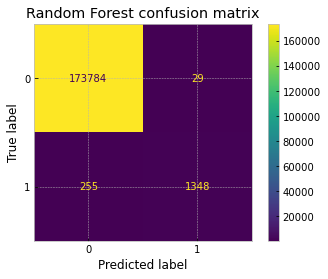

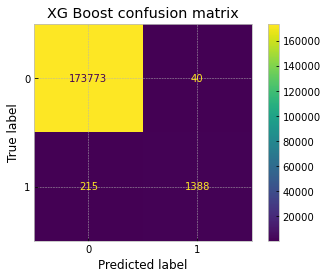

In [46]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
cm1 = confusion_matrix(y_test, y_pred_random, labels=model_random.classes_)
ax = ConfusionMatrixDisplay(confusion_matrix=cm1,
                            display_labels=model_random.classes_)

cm2 = confusion_matrix(y_test, y_pred_XGBC, labels=model_XGBC.classes_)
ax2 = ConfusionMatrixDisplay(confusion_matrix=cm2,
                              display_labels=model_XGBC.classes_)

ax.plot()

plt.title("Random Forest confusion matrix")
ax2.plot()

plt.title("XG Boost confusion matrix")
plt.show()



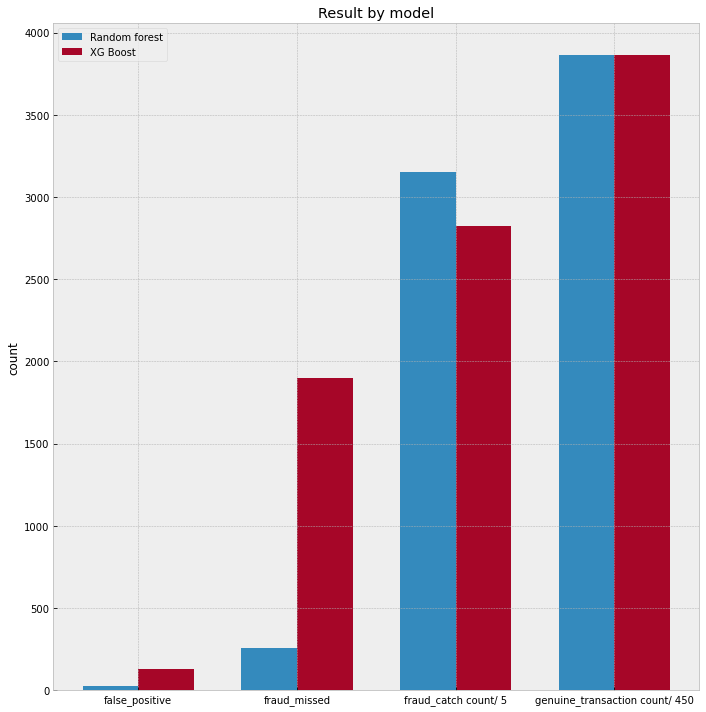

In [47]:
labels = ['false_positive', 'fraud_missed', 'fraud_catch count/ 5', "genuine_transaction count/ 450"]
random_forest = [result.false_positive_rf.sum(), result.fraud_missed_rf.sum(), 
                 (result.fraud_catch_rf.sum()/5),(result.genuine_transaction_rf.sum()/450)]
XGBC = [result.false_positive_XGB.sum(), result.fraud_missed_XGB.sum(), 
                 (result.fraud_catch_XGB.sum()/5), (result.genuine_transaction_XGB.sum()/450)]

x = np.arange(len(labels))  
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(x - width/2, random_forest, width, label="Random forest")
rects2 = ax.bar(x + width/2, XGBC, width, label="XG Boost")

ax.set_ylabel('count')
ax.set_title('Result by model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [48]:
result.sample(1000)

,TRANSACTION_ID,TX_AMOUNT,TX_FRAUD_SCENARIO,TX_FRAUD,fraud_prediction_random_forest,fraud_prediction_rate_random_forest,false_positive_rf,fraud_missed_rf,fraud_catch_rf,genuine_transaction_rf,fraud_prediction_XGB,fraud_prediction_rate_XGB,false_positive_XGB,fraud_missed_XGB,fraud_catch_XGB,genuine_transaction_XGB
1446616,1446616,93.67,0,0,0,0.0,0,0,0,1,0,0.000004,0,0,0,1
1655874,1655874,79.03,0,0,0,0.0,0,0,0,1,0,0.000005,0,0,0,1
230163,230163,68.60,0,0,0,0.0,0,0,0,1,0,0.000004,0,0,0,1
1124827,1124827,79.33,0,0,0,0.0,0,0,0,1,0,0.000026,0,0,0,1
413964,413964,57.21,0,0,0,0.0,0,0,0,1,0,0.000038,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445451,445451,80.77,0,0,0,0.0,0,0,0,1,0,0.015310,0,0,0,1
497887,497887,90.86,0,0,0,0.0,0,0,0,1,0,0.000003,0,0,0,1
713842,713842,106.41,0,0,0,0.0,0,0,0,1,0,0.000008,0,0,0,1
1481048,1481048,32.86,0,0,0,0.0,0,0,0,1,0,0.000005,0,0,0,1


In [49]:
list_1 = [[str(round(x,2))]for x in np.arange(0,1,0.05)]
losses_df = pd.DataFrame(list_1, columns=["fraud_prediction_rate"])

list_fraud_catch_XGB = []
for i in np.arange(0,1,0.05):    
    temp = result[(result.fraud_prediction_rate_XGB < round(i,2)) & 
                  (result.TX_FRAUD == 1)].TX_AMOUNT.sum() 
    list_fraud_catch_XGB.append(round(temp,2))
losses_df.insert(1, "Amount of fraud catch XG Boost", list_fraud_catch_XGB, True)

list_fraud_false_positive_XGB = []
for i in np.arange(0,1,0.05):    
    temp = result[(result.fraud_prediction_rate_XGB > round(i,2)) & 
                  (result.TX_FRAUD == 0)].TX_AMOUNT.sum() 
    list_fraud_false_positive_XGB.append(round(temp,2))
    
losses_df.insert(1, "Amount of false positive XG Boost", list_fraud_false_positive_XGB, True)
    
list_fraud_catch_rf = []
for i in np.arange(0,1,0.05):    
    temp = result[(result.fraud_prediction_rate_random_forest < round(i,2)) & 
                  (result.TX_FRAUD == 1)].TX_AMOUNT.sum() 
    list_fraud_catch_rf.append(round(temp,2))
losses_df.insert(1, "Amount of fraud catch random forest", list_fraud_catch_rf, True)

list_fraud_false_positive_rf = []
for i in np.arange(0,1,0.05):    
    temp = result[(result.fraud_prediction_rate_random_forest > round(i,2)) & 
                  (result.TX_FRAUD == 0)].TX_AMOUNT.sum() 
    list_fraud_false_positive_rf.append(round(temp,2))
    
losses_df.insert(1, "Amount of false positive Random forest", list_fraud_false_positive_rf, True)


In [50]:
losses_df.set_index("fraud_prediction_rate", inplace=True)

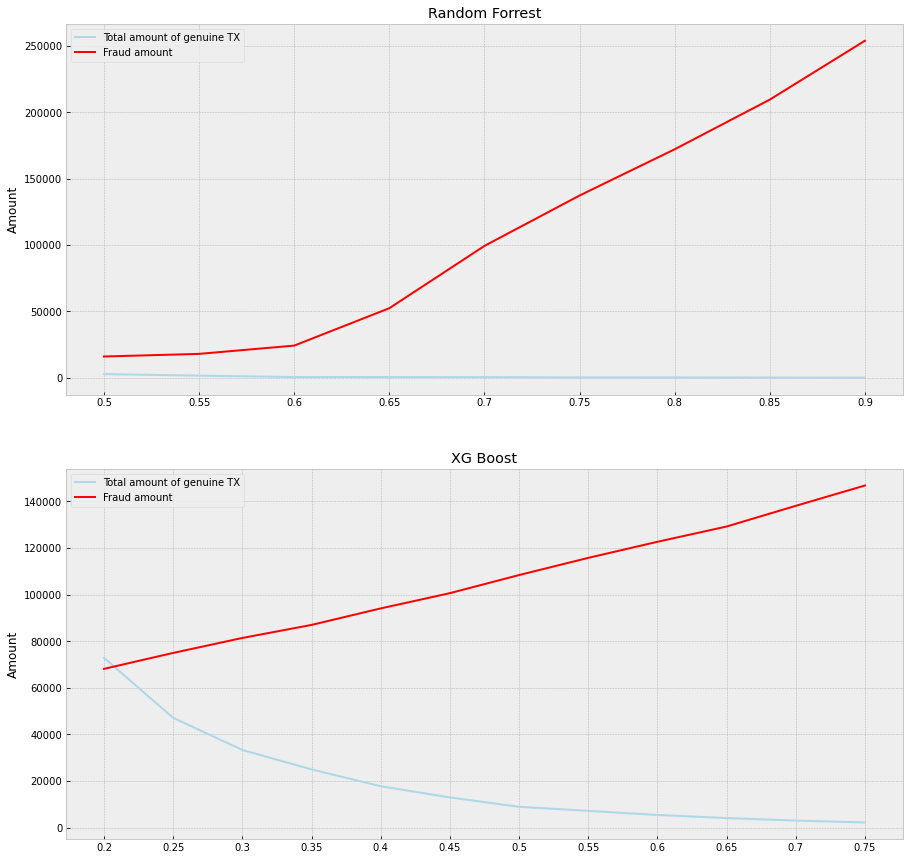

In [51]:
fig, ax = plt.subplots(2,1,figsize=(15, 15))

ax[0].plot(losses_df[["Amount of false positive Random forest"]][10:-1], 
           label = "Total amount of genuine TX", color="lightblue")
ax[0].plot(losses_df[["Amount of fraud catch random forest"]][10:-1],label = "Fraud amount", color="red")
ax[0].set_ylabel("Amount")
ax[0].title.set_text("Random Forrest")
ax[0].legend()

ax[1].plot(losses_df[["Amount of false positive XG Boost"]][4:-4],
           label = "Total amount of genuine TX", color="lightblue")
ax[1].plot(losses_df[["Amount of fraud catch XG Boost",]][4:-4],label = "Fraud amount", color="red")
ax[1].set_ylabel("Amount")
ax[1].title.set_text("XG Boost")
ax[1].legend()


plt.show()

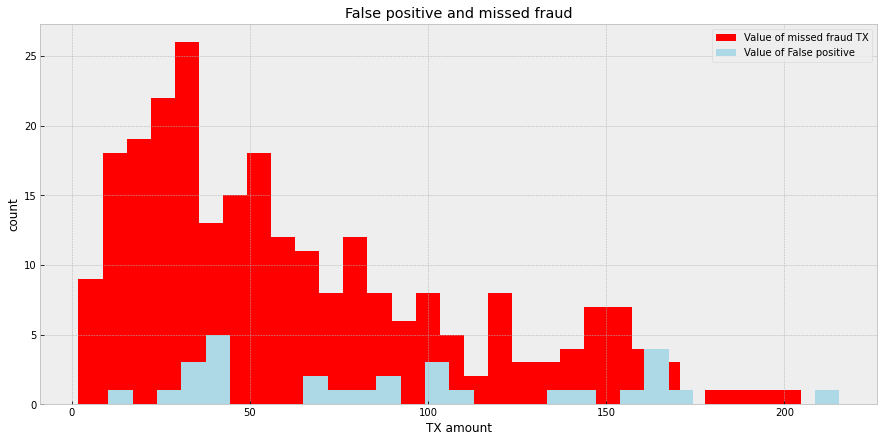

In [52]:
fig, ax = plt.subplots(figsize=(15,7))

ax.hist(result[["TX_AMOUNT",]][result.fraud_missed_rf == 1], 
           label = "Value of missed fraud TX", color="red", bins=30)
ax.hist(result[["TX_AMOUNT",]][result.false_positive_rf == 1], 
           label = "Value of False positive", color="lightblue",bins=30)


ax.set_ylabel("count")
ax.set_xlabel("TX amount")
ax.title.set_text("False positive and missed fraud")
ax.legend()


plt.show()

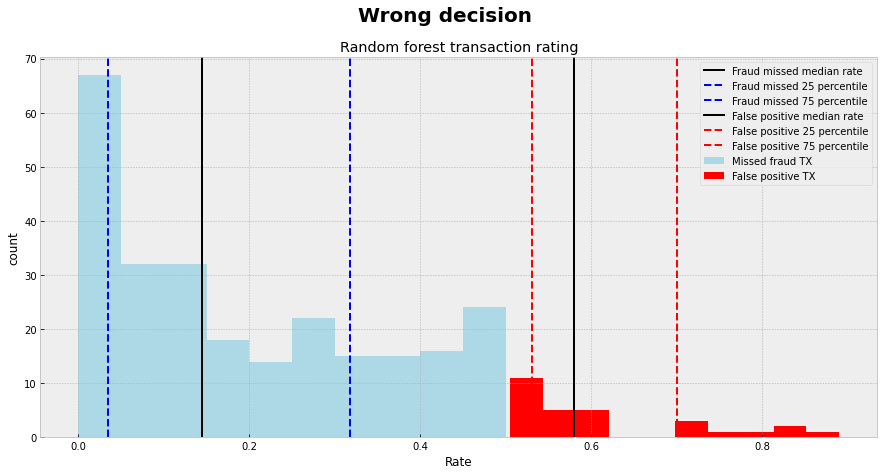

In [53]:
fig, ax = plt.subplots(figsize=(15,7))
fig.suptitle("Wrong decision", fontsize=20, fontweight='bold')


ax.hist(result[["fraud_prediction_rate_random_forest"]][result.fraud_missed_rf == 1],
           label = "Missed fraud TX",color="lightblue")
ax.axvline(x=((result[["fraud_prediction_rate_random_forest"]][result.fraud_missed_rf == 1])
                 .median().item()),color="black",label = "Fraud missed median rate")
ax.axvline(x=(np.percentile((result[["fraud_prediction_rate_random_forest"]][result.fraud_missed_rf == 1]),
                               [25]).item()), label = "Fraud missed 25 percentile",color="blue",ls="--")
ax.axvline(x=(np.percentile((result[["fraud_prediction_rate_random_forest"]][result.fraud_missed_rf == 1]),
                               [75]).item()), label = "Fraud missed 75 percentile",color="blue",ls="--")



ax.hist(result[["fraud_prediction_rate_random_forest"]][result.false_positive_rf == 1],
           label = "False positive TX",color="red")
ax.axvline(x=((result[["fraud_prediction_rate_random_forest"]][result.false_positive_rf == 1])
                 .median().item()),color="black",label = "False positive median rate")
ax.axvline(x=(np.percentile((result[["fraud_prediction_rate_random_forest"]][result.false_positive_rf == 1]),
                               [25]).item()), label = "False positive 25 percentile",color="red",ls="--")
ax.axvline(x=(np.percentile((result[["fraud_prediction_rate_random_forest"]][result.false_positive_rf == 1]),
                               [75]).item()), label = "False positive 75 percentile",color="red",ls="--")
    
    
ax.set_ylabel("count")
ax.set_xlabel("Rate")
ax.title.set_text("Random forest transaction rating")
ax.legend()

plt.show()

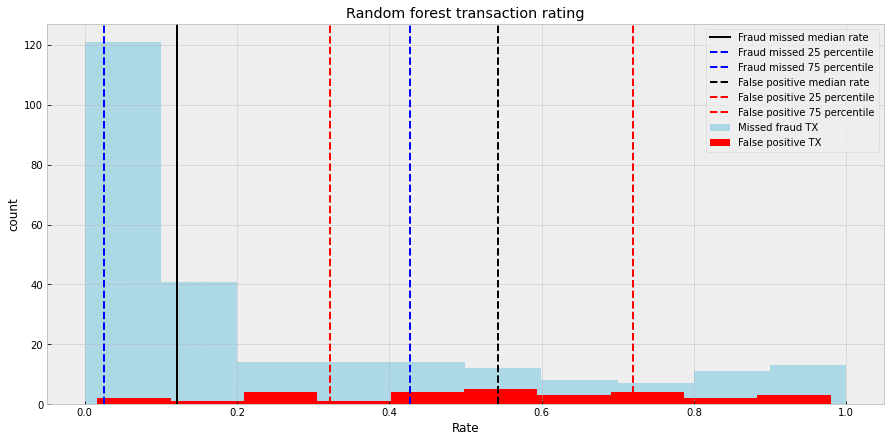

In [54]:
ig, ax = plt.subplots(figsize=(15,7))
fig.suptitle("Wrong decision", fontsize=20, fontweight='bold')


ax.hist(result[["fraud_prediction_rate_XGB"]][result.fraud_missed_rf == 1],
           label = "Missed fraud TX",color="lightblue")
ax.axvline(x=((result[["fraud_prediction_rate_XGB"]][result.fraud_missed_rf == 1])
                 .median().item()),color="black",label = "Fraud missed median rate")
ax.axvline(x=(np.percentile((result[["fraud_prediction_rate_XGB"]][result.fraud_missed_rf == 1]),
                               [25]).item()), label = "Fraud missed 25 percentile",color="blue",ls="--")
ax.axvline(x=(np.percentile((result[["fraud_prediction_rate_XGB"]][result.fraud_missed_rf == 1]),
                               [75]).item()), label = "Fraud missed 75 percentile",color="blue",ls="--")



ax.hist(result[["fraud_prediction_rate_XGB"]][result.false_positive_rf == 1],
           label = "False positive TX",color="red")
ax.axvline(x=((result[["fraud_prediction_rate_XGB"]][result.false_positive_rf == 1])
                 .median().item()),color="black",label = "False positive median rate",ls="--")
ax.axvline(x=(np.percentile((result[["fraud_prediction_rate_XGB"]][result.false_positive_rf == 1]),
                               [25]).item()), label = "False positive 25 percentile",color="red",ls="--")
ax.axvline(x=(np.percentile((result[["fraud_prediction_rate_XGB"]][result.false_positive_rf == 1]),
                               [75]).item()), label = "False positive 75 percentile",color="red",ls="--")
    
    
ax.set_ylabel("count")
ax.set_xlabel("Rate")
ax.title.set_text("Random forest transaction rating")
ax.legend()

plt.show()

# engine

In [55]:
sample_df = transactions_df.sample(10000)


sample_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,temp_date,...,hour_4_4,average_tx_last1days,tx_count_over_last1days,average_tx_last7days,tx_count_over_last7days,average_tx_last30days,tx_count_over_last30days,average_terminal_fraud_rate_last15days,average_terminal_fraud_rate_last30days,upper_outlier_distance
1634781,1634781,2018-09-18 12:43:16,768,7801,32.06,14733796,170,0,0,2018-09-18,...,0,32.060000,1.0,89.603846,13.0,92.615490,51.0,0.0,0.000000,0.000000
1065501,1065501,2018-07-21 05:26:59,4933,5573,70.60,9610019,111,0,0,2018-07-21,...,0,99.762857,7.0,86.509583,24.0,92.750082,122.0,0.0,0.000000,0.000000
552682,552682,2018-05-28 13:01:29,4692,3904,8.91,4971689,57,0,0,2018-05-28,...,0,33.650000,4.0,38.065000,26.0,34.707685,108.0,0.0,0.000000,0.000000
414566,414566,2018-05-14 07:28:54,4644,7895,56.29,3742134,43,0,0,2018-05-14,...,0,41.950000,4.0,42.341667,6.0,37.585806,31.0,0.0,0.030303,1.392514
401982,401982,2018-05-12 18:05:13,2213,3471,107.72,3607513,41,0,0,2018-05-12,...,0,116.530000,3.0,77.999630,27.0,78.643059,85.0,0.0,0.000000,0.075177


In [56]:
sample_df[:1]

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,temp_date,...,hour_4_4,average_tx_last1days,tx_count_over_last1days,average_tx_last7days,tx_count_over_last7days,average_tx_last30days,tx_count_over_last30days,average_terminal_fraud_rate_last15days,average_terminal_fraud_rate_last30days,upper_outlier_distance
1634781,1634781,2018-09-18 12:43:16,768,7801,32.06,14733796,170,0,0,2018-09-18,...,0,32.06,1.0,89.603846,13.0,92.61549,51.0,0.0,0.0,0.0


Faire graph avec les trois distributions

In [57]:
#border control, faire une fonction qui va couvrir les missed fraud si random forest sort 0 et
#et les falses positives si ça sort 1

In [58]:
sample_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,temp_date,...,hour_4_4,average_tx_last1days,tx_count_over_last1days,average_tx_last7days,tx_count_over_last7days,average_tx_last30days,tx_count_over_last30days,average_terminal_fraud_rate_last15days,average_terminal_fraud_rate_last30days,upper_outlier_distance
1634781,1634781,2018-09-18 12:43:16,768,7801,32.06,14733796,170,0,0,2018-09-18,...,0,32.060000,1.0,89.603846,13.0,92.615490,51.0,0.0,0.000000,0.000000
1065501,1065501,2018-07-21 05:26:59,4933,5573,70.60,9610019,111,0,0,2018-07-21,...,0,99.762857,7.0,86.509583,24.0,92.750082,122.0,0.0,0.000000,0.000000
552682,552682,2018-05-28 13:01:29,4692,3904,8.91,4971689,57,0,0,2018-05-28,...,0,33.650000,4.0,38.065000,26.0,34.707685,108.0,0.0,0.000000,0.000000
414566,414566,2018-05-14 07:28:54,4644,7895,56.29,3742134,43,0,0,2018-05-14,...,0,41.950000,4.0,42.341667,6.0,37.585806,31.0,0.0,0.030303,1.392514
401982,401982,2018-05-12 18:05:13,2213,3471,107.72,3607513,41,0,0,2018-05-12,...,0,116.530000,3.0,77.999630,27.0,78.643059,85.0,0.0,0.000000,0.075177


In [59]:
sample_df.sample(10).CUSTOMER_ID.item()

ValueError: can only convert an array of size 1 to a Python scalar

In [ ]:
def terminal_hist (terminal_id, window_days, period_uncertainty = 10):

#sort terminaid by date time and reindex the df
    
    terminal_id_temp_df = terminal_id.sort_values("TX_DATETIME")
    terminal_id_temp_df.index = terminal_id_temp_df["TX_DATETIME"]

#for loop that will sum number of transaction and average amount on defined period for 
    for period in window_days:
        count_genuine_tran_period = terminal_id_temp_df["TX_FRAUD"].rolling(min_periods= period_uncertainty, 
                                                                            window = (str(period) + "d")).count()
        count_fraudulent__tran_period =terminal_id_temp_df["TX_FRAUD"].rolling(str(period)+"d").sum()
        fraud_rate_period = count_fraudulent__tran_period/count_genuine_tran_period
        
        terminal_id_temp_df["average_terminal_fraud_rate_last"+ str(period) + "days"] = fraud_rate_period


    return terminal_id_temp_df

In [ ]:
def border_control (pop):
    median = transactions_df.TX_AMOUNT[
        (transactions_df.CUSTOMER_ID == pop.CUSTOMER_ID.item()) & 
        (transactions_df.TX_TIME_SECONDS < pop.TX_TIME_SECONDS.item())].median()
    ecart_moyen = stats.median_abs_deviation(transactions_df.TX_AMOUNT[
        (transactions_df.CUSTOMER_ID == pop.CUSTOMER_ID.item()) & 
        (transactions_df.TX_TIME_SECONDS < pop.TX_TIME_SECONDS.item())])
    
    outlier = pop.TX_AMOUNT.item()
    
    z_score = stats.zscore(transactions_df.TX_AMOUNT[
        (transactions_df.CUSTOMER_ID == pop.CUSTOMER_ID.item()) & 
        (transactions_df.TX_TIME_SECONDS < pop.TX_TIME_SECONDS.item())])



    return median, ecart_moyen, outlier, z_score

In [ ]:
border_control(sample_df.sample(1))

In [ ]:
pop = sample_df.sample(1)
pop.sample()

In [ ]:
transactions_df[(transactions_df.CUSTOMER_ID == pop.CUSTOMER_ID.item()) & 
                                  (transactions_df.TX_TIME_DAYS < pop.TX_TIME_DAYS.item())]

In [ ]:
false_limit = np.percentile((result[["fraud_prediction_rate_random_forest"]][result.false_positive_rf == 1]),[75]).item()

In [ ]:
def test_engine (pop):
    pop_engine = pop[['TX_AMOUNT', 'is_monday', 'is_tuesday', 'is_wednesday',
       'is_thursday', 'is_friday', 'is_saturday', 'is_sunday', 'hour_1_4',
       'hour_2_4', 'hour_3_4', 'hour_4_4', 'average_tx_last1days',
       'tx_count_over_last1days', 'average_tx_last7days',
       'tx_count_over_last7days', 'average_tx_last30days',
       'tx_count_over_last30days','average_terminal_fraud_rate_last15days',
       'average_terminal_fraud_rate_last30days']]
    
    check = []
    check.append(pop.CUSTOMER_ID.item())
    rating = model_random.predict_proba(pop_engine)
    binary = model_random.predict(pop_engine)
    
    sample_df["rating"] = rating
    
    return check

In [ ]:
test_engine(sample_df.sample(10))

In [ ]:
def decision_engine (pop, rating_pass,rating_review):
    pop_engine = pop[['TX_AMOUNT', 'is_monday', 'is_tuesday', 'is_wednesday',
       'is_thursday', 'is_friday', 'is_saturday', 'is_sunday', 'hour_1_4',
       'hour_2_4', 'hour_3_4', 'hour_4_4', 'average_tx_last1days',
       'tx_count_over_last1days', 'average_tx_last7days',
       'tx_count_over_last7days', 'average_tx_last30days',
       'tx_count_over_last30days','average_terminal_fraud_rate_last15days',
       'average_terminal_fraud_rate_last30days']]
    
    
    rating = model_random.predict_proba(pop_engine)[:,1]
    result = []
    std = []
    
    pop = sample_df[:1]
    
    for i in pop:
        time = pop["TX_TIME_SECONDS"].item()
        cust_id = pop["CUSTOMER_ID"].item()
        mean_temp = sample_df[(sample_df.index < time) & (sample_df.CUSTOMER_ID == cust_id)].TX_AMOUNT.mean()
        median_temp = sample_df[(sample_df.index < time) & (sample_df.CUSTOMER_ID == cust_id)].TX_AMOUNT.median()
        print(median_temp)

    
    for score in rating:
        if score <= rating_pass:
            result.append("approved")
        elif score <= rating_review:
            result.append("review")
        elif score > rating_review:
            result.append("deny")
            
    return rating


In [ ]:
decision_engine(sample_df.sample(10), 0.5, 0.7)

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
clf = IsolationForest(max_samples=100, random_state=42)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
#y_pred_outliers = clf.predict(X_outliers)

In [ ]:
y_pred_test